In [24]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector, Operator, Pauli
import warnings
warnings.filterwarnings('ignore')
import uuid


Total thetas: 100
Theta = 0.000, Max S = 1.405, Best Angles = {'A1': np.float64(0.0), 'A2': np.float64(1.5707963267948966), 'B1': np.float64(0.8975979010256552), 'B2': np.float64(-0.6731984257692414)}
Theta = 0.063, Max S = 1.494, Best Angles = {'A1': np.float64(0.4487989505128276), 'A2': np.float64(2.019595277307724), 'B1': np.float64(1.3463968515384828), 'B2': np.float64(-0.2243994752564138)}
Theta = 0.127, Max S = 1.583, Best Angles = {'A1': np.float64(1.7951958020513104), 'A2': np.float64(0.2243994752564138), 'B1': np.float64(0.8975979010256552), 'B2': np.float64(2.4683942278205517)}
Theta = 0.190, Max S = 1.671, Best Angles = {'A1': np.float64(4.487989505128276), 'A2': np.float64(2.9171931783333793), 'B1': np.float64(0.4487989505128276), 'B2': np.float64(2.019595277307724)}
Theta = 0.254, Max S = 1.758, Best Angles = {'A1': np.float64(1.7951958020513104), 'A2': np.float64(3.365992128846207), 'B1': np.float64(5.834386356666759), 'B2': np.float64(4.263590029871862)}
Theta = 0.317, M

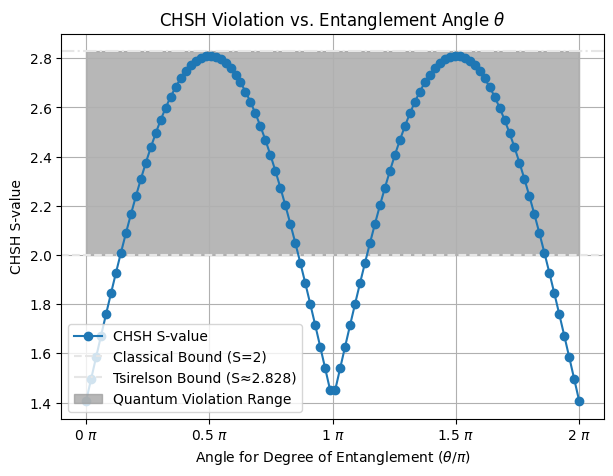

In [25]:

##############################################################################
# 1. Create PARTIALLY entangled state:
#    cos(theta/2)|00> + sin(theta/2)|11>
##############################################################################
def create_entangled_state(theta):
    qc = QuantumCircuit(2)
    qc.ry(theta, 0)  
    qc.cx(0, 1)
    return qc

##############################################################################
# 2. Measure <Z \otimes Z> after local R_y() rotations on each qubit
##############################################################################
def measure_correlation(state, angle_qubit_0, angle_qubit_1):
    """
    Rotate qubit 0 by 'angle_qubit_0' and qubit 1 by 'angle_qubit_1'
    around Y, then measure Z \otimes Z. Return real number in [-1, +1].
    """
    # R_y(angle) = [[ cos(angle/2), -sin(angle/2)],
    #                [ sin(angle/2),  cos(angle/2)]]
    rotation_0 = Operator([
        [np.cos(angle_qubit_0/2), -np.sin(angle_qubit_0/2)],
        [np.sin(angle_qubit_0/2),  np.cos(angle_qubit_0/2)]
    ])
    rotation_1 = Operator([
        [np.cos(angle_qubit_1/2), -np.sin(angle_qubit_1/2)],
        [np.sin(angle_qubit_1/2),  np.cos(angle_qubit_1/2)]
    ])
    
    # Apply local R_y to each qubit index
    rotated_state = state.evolve(rotation_0, [0]).evolve(rotation_1, [1])
    
    # Now measure Pauli('ZZ')
    correlation = np.real(rotated_state.expectation_value(Pauli('ZZ')))
    return correlation

##############################################################################
# 3. Compute CHSH S-value
##############################################################################
def chsh_s_value(state, angles):
    """
    angles = {
      'A1': float,
      'A2': float,
      'B1': float,
      'B2': float
    }
    S = | <A1 B1> + <A1 B2> + <A2 B1> - <A2 B2> |
    """
    A1B1 = measure_correlation(state, angles['A1'], angles['B1'])
    A1B2 = measure_correlation(state, angles['A1'], angles['B2'])
    A2B1 = measure_correlation(state, angles['A2'], angles['B1'])
    A2B2 = measure_correlation(state, angles['A2'], angles['B2'])
    return abs(A1B1 + A1B2 + A2B1 - A2B2)

##############################################################################


if __name__ == "__main__":
    thetas = np.linspace(0, 2*np.pi, 100)
    print(f"Total thetas: {len(thetas)}")

    backend = Aer.get_backend('statevector_simulator')
    circuits = []

    for idx, theta in enumerate(thetas):
        qc = create_entangled_state(theta)
        qc.name = f"theta_{idx}_{uuid.uuid4()}"
        qc.save_statevector(label=f"state_{idx}")
        circuits.append(qc)

    transpiled_circuits = transpile(circuits, backend=backend)
    job = backend.run(transpiled_circuits)
    result = job.result()

    #prepare angle values for scanning
    #     (We pick a1_values and b1_values, and let A2 = A1 +/- pi/2, B2 = B1 +/- pi/2)
    a1_values = np.linspace(0, 2*np.pi, 15)
    b1_values = np.linspace(0, 2*np.pi, 15)

    max_s_list = [] 
    all_s_vals=[]

    #Loop over each theta -> retrieve state -> find max S
    for idx, theta in enumerate(thetas):
        # Retrieve statevector
        qc_name = transpiled_circuits[idx].name
        sv = result.data(qc_name)[f"state_{idx}"]
        state = Statevector(sv)

        best_s = float('-inf')
        best_angles = None

        #loops over A1, B1, plus the +/- pi/2 offset
        for A1 in a1_values:
            A2_options = [A1 + np.pi/2, A1 - np.pi/2]
            for A2 in A2_options:
                for B1 in b1_values:
                    B2_options = [B1 + np.pi/2, B1 - np.pi/2]
                    for B2 in B2_options:
                        angles = {'A1': A1, 'A2': A2, 'B1': B1, 'B2': B2}
                        s_val = chsh_s_value(state, angles)
                        all_s_vals.append(s_val)
                        if s_val > best_s:
                            best_s = s_val
                            best_angles = angles
        
        #SAVE ebst theta
        max_s_list.append({
            'theta': theta,
            'max_S': best_s,
            'angles': best_angles
        })

        print(f"Theta = {theta:.3f}, Max S = {best_s:.3f}, Best Angles = {best_angles}")
# Normalize theta values by dividing by pi                                                                           why?                                                                          why? 
normalized_thetas = thetas/ np.pi

# Plot Results
import matplotlib.ticker as tck

# Plot Results with Updated Formatting
fig, ax = plt.subplots(figsize=(7, 5))



# Plot the CHSH S-values
ax.plot(normalized_thetas, [result['max_S'] for result in max_s_list], "o-", label="CHSH S-value", zorder=3)

# Classical and quantum bounds
ax.axhline(y=2, color="0.9", linestyle="--", label="Classical Bound (S=2)")
ax.axhline(y=2 * np.sqrt(2), color="0.9", linestyle="-.", label="Tsirelson Bound (S≈2.828)")
ax.fill_between(normalized_thetas, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7, label="Quantum Violation Range")

# Format x-axis ticks
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5)) # Every 0.5 π


# Labels, legend, and grid
plt.xlabel("Angle for Degree of Entanglement ($\\theta / \\pi$)")      # why do we show the angle divided by pi and it's still with pi on the axis?
plt.ylabel("CHSH S-value")
plt.title("CHSH Violation vs. Entanglement Angle $\\theta$")
plt.legend()
plt.grid(True)

plt.show()
